In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Create CLV model with lifetime package    
LTV = expected number of transactions * revenue per transactions * margin    
- BG/NBD model: predict 1) expected number of transactions; 2) probability of being alive    
- Gamma-Gamma model: predict expected monetary value per transaction    
- Margin is defined by business, e.g., discount, campaign, something relates to the price

In [4]:
df = pd.read_csv("Online+Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


### Data preprocessing

In [5]:
df.shape

(541909, 8)

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# number of customers in the dataset
df['CustomerID'].nunique()

4372

#### Data cleansing
customerID: remove missing values, because the model is built on specific customers.    
Quantity: remove negative records (the data is based on accounting records, positive records have related negative records)

In [9]:
dfnew = df[(df.Quantity>0) & (df.CustomerID.isnull() == False)]

dfnew['amt'] = dfnew['Quantity'] * dfnew['UnitPrice']
dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date

#### Feature aggregation
The lifetime package is based on transaction data only. For each customer, aggregate:
- recency: days between first and last purchase (in the given period)
- frequency: number of transactions (in the given period)
- T: customer age, days since first purchase
- monetary_value: transaction value (in the given period)

In [10]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(dfnew, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2011-12-9')
modeldata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


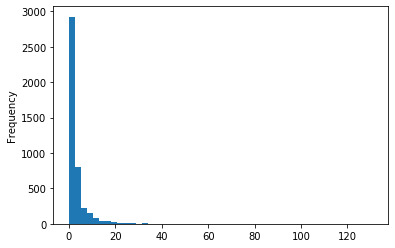

In [11]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

In [12]:
dfnew[dfnew.CustomerID == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amt
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,77183.6


### BG model
- penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough

In [13]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


#### Frequency-recency matrix

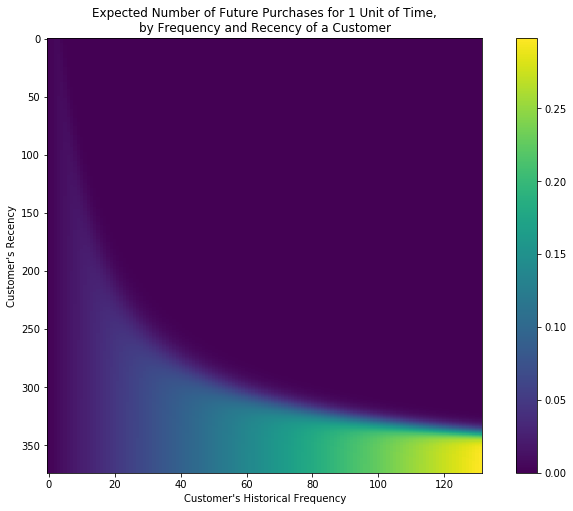

In [16]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

Target: expected number of purchase in next 1 day    
X-axis: frequency    
Y-axis: recency    
- Up-right: dark, rare chance of purchase, people have high frequency, but rarely buy things recently, they might quit the product/your business
- Diagonal: blue curve, relatively good customer    

**Recency is more important than frequency**. People with good recency (bottom) is more likely to buy than people with high frequency but bad recency (up left).

#### Churn/Active Probability

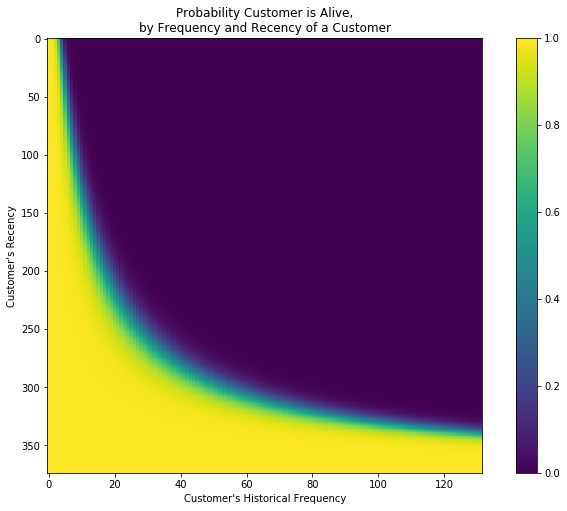

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

- Up-right: dead/silent
- Bottom-left: high activity. Active probability decrease exponentially with recency (time between first and last purchase) decrease.

#### Predict future transaction number

In [17]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])


In [18]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


In [19]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18074.0,0.0,0.0,373.0,0.0,0.00187
16048.0,0.0,0.0,373.0,0.0,0.00187
16274.0,0.0,0.0,373.0,0.0,0.00187
14237.0,0.0,0.0,373.0,0.0,0.00187
14142.0,0.0,0.0,373.0,0.0,0.00187


#### Model validation: period transaction plot

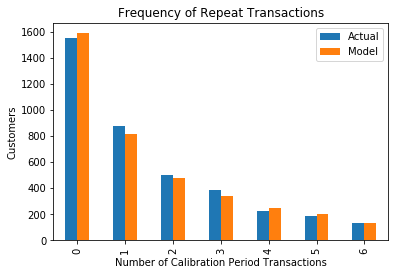

In [20]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

X-axis: number of transactions in calibration period (whole training data)    
Error: gap between two bars    

The model is good because:
-	**accurate**: Gaps between two bars are small
-	**stable**: Two bars decline consistently.    
If the pattern (two bars) is not declining consistently, the model is not stable.
-	There are both positive and negative errors, the error is random.     
If the model prediction is always larger/smaller than actual, the model is not good because the error is not random, there’s still room for the model to be improved.

#### Model validation: split calibration and holdout sets
Partition data into two parts. Fit the model on calibration (train) set, test on future/holdout.

In [21]:
summary_cal_holdout = calibration_and_holdout_data(dfnew, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   


In [22]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184
12347.0,2.0,121.0,183.0,4.0,184
12348.0,2.0,110.0,174.0,1.0,184
12350.0,0.0,0.0,126.0,0.0,184
12352.0,3.0,34.0,112.0,3.0,184


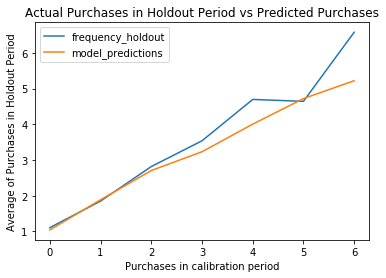

In [23]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


The model is good because model prediction (orange line) and true data (blue line) overlap.

In [24]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15170360805212538

#### Historical probability of being alive    
With the CLV model we have created, we can specifically estimate a customer's historical probability of being alive.

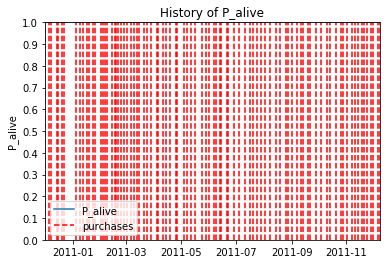

In [26]:
id = 14606
days_since_birth = 365
sp_trans = dfnew.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

Customer 14606    
Best customer, alive throughout the year

### Gamma-Gamma model
Predict average monetary value per transaction. If we know the price and historical transactions of a specific customer, then we can apply Gamma-Gamma model to predict most likely monetary value **per transaction** in the future.    
#### Focus on customers with repurchase behavior
Focus on estimating the customers who had at least one repeat purchase. Because customer with only one purchase is very less likely to make additional purchase. It’s difficult to save/wake up these silent customers.

In [27]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [29]:
# 64% customer left
len(returning_customers_summary)/len(modeldata)

0.6430053007605439

In [30]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [31]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64

## Create CLV model Xgboost and Lightgbm Algorithm
Features:    
- customerID
- latetime: days between last transaction to now
- earlytime: days between first transaction to now
- freq: transaction frequency (whole history)
- freq_3m: transaction frequency (recent 3 months history)
- score (from other data scource)
- discount (from other data scource)
    
Target: number of transactions in test set

In [34]:
import datetime

dfnew_train = dfnew[dfnew.InvoiceDate < datetime.date(2011, 11, 9)]
dfnew_test = dfnew[dfnew.InvoiceDate >= datetime.date(2011, 11, 9)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfnew_train['freq'] =1 
dfsum3 = dfnew_train.groupby(['CustomerID'])['freq'].sum().reset_index()

# get transaction frequency (recent 3 months history)
dfnew_train['freq_3m'] =1 
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['freq_3m'].sum().reset_index()

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# other_data: customerID, score, discount
other_data = pd.read_csv('oth.csv')
dfsum = pd.merge(dfsum, other_data, on=['CustomerID'], how='left')

# get target: number of transactions in test set
dfnew_test['target'] = 1
dfsum_target = dfnew_test.groupby(['CustomerID'])['target'].sum().reset_index()

dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [35]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,score,discount,target
1216,14096.0,8.0,70.0,2688,2688.0,0.0,13.0,2423.0
300,12748.0,0.0,342.0,2945,1070.0,70118.0,10.0,1651.0
3766,17841.0,0.0,342.0,6309,2548.0,81346.0,9.0,1538.0
1770,14911.0,1.0,342.0,4566,2066.0,95982.0,8.0,1111.0
2896,16549.0,0.0,303.0,511,368.0,100000.0,7.0,470.0
1572,14606.0,1.0,342.0,2364,531.0,97479.0,6.0,336.0
1463,14456.0,9.0,111.0,645,404.0,97218.0,7.0,325.0
2772,16360.0,7.0,57.0,372,372.0,96335.0,5.0,290.0
2052,15311.0,4.0,342.0,2104,535.0,95428.0,5.0,275.0
4065,18283.0,12.0,306.0,487,87.0,95766.0,6.0,269.0


### xgb model

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 5)
 
predictors = ['latetime','earlytime', 'freq','freq_3m', 'score','discount']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=2200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [42]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE: ', rmse)

RMSE:  14.217870373519059


#### Feature importance
importance_type:
- ‘weight’ - the number of times a feature is used to split the data across all trees.
- ‘gain’ - the average gain across all splits the feature is used in. most popular way.
- ‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)
- ‘total_gain’ - the total gain across all splits the feature is used in.
- ‘total_cover’ - the total coverage across all splits the feature is used in.

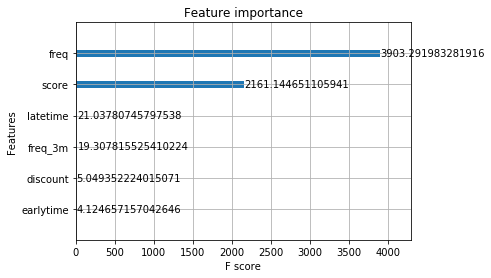

In [37]:
xgb.plot_importance(xgb_model, importance_type='gain')

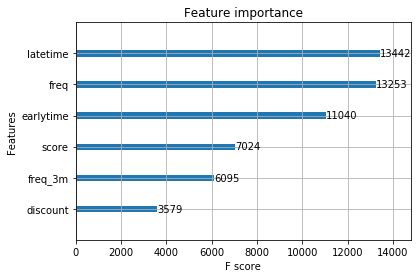

In [38]:
xgb.plot_importance(xgb_model, importance_type='weight')

### lgb model

In [48]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 5, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m', 'score','discount']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              learning_rate=0.02, max_depth=5, metric='mse',
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2200, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [49]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE: ', rmse)

RMSE:  24.778582377785874


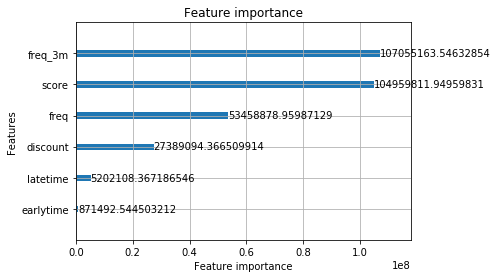

In [50]:
lgb.plot_importance(lgb_model, importance_type='gain')

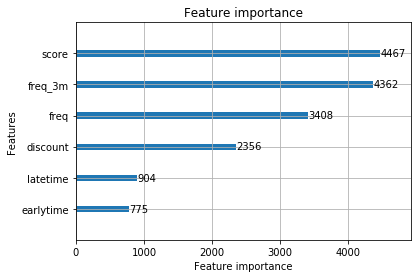

In [51]:
lgb.plot_importance(lgb_model) # defualt: weight

## Appendix

### Code to create fake features: score, discount

In [33]:
import datetime
A = dfnew[dfnew.InvoiceDate>datetime.date(2011, 11, 9)]
Z = pd.DataFrame(A.CustomerID.value_counts()).reset_index()
Z.columns = ['CustomerID','buytime']
allcus = pd.DataFrame(set(dfnew.CustomerID), columns = ['CustomerID'])
allcus = pd.merge(allcus, Z, on=['CustomerID'], how='left').sort_values(['buytime'], ascending = False)
allcus = allcus.fillna(0)
allcus['buytime'] = allcus['buytime']/allcus['buytime'].max()

allcus['v1'] = allcus['buytime']*0.78 + np.random.normal(0, 0.11, len(allcus))
allcus['v2'] = allcus['buytime']*allcus['buytime']*(-0.195) + 0.11*allcus['buytime']
allcus.corr()

allcus['v1'] = (allcus['v1'] - allcus['v1'].min())/(allcus['v1'].max() - allcus['v1'].min())
allcus['v2'] = (allcus['v2'] - allcus['v2'].min())/(allcus['v2'].max() - allcus['v2'].min())
allcus['score'] = round(allcus['v2']*100000)
allcus.score.max()

allcus['discount'] = round(allcus['v1']*12.6)

allcus['r'] = np.random.randint(100,size=len(allcus))

def def2(D):
    if D['r']<13:
        x = 0
    else:
        x = D['discount']
    return x

allcus['discount'] = allcus.apply(def2, axis = 1)

v = ['CustomerID', 'score', 'discount']
allcus = allcus[v]

allcus = allcus.sort_values(['score'])

allcus.score.std()
allcus.corr()

allcus.to_csv('oth.csv', index = False)